### **Patch Creation:**
The ViT model divides an input image into fixed-size non-overlapping patches, treating each patch as a token.

### **Patch Embedding:**
These patches are linearly embedded and concatenated to form a sequence, serving as the input to the transformer architecture.

### **Attention:**
The transformer's attention mechanism enables the model to weigh the importance of different patches in relation to each other, allowing it to capture long-range dependencies crucial for understanding the context of the entire image.

# Dataset

170498071/170498071 [==============================] - 6s 0us/step


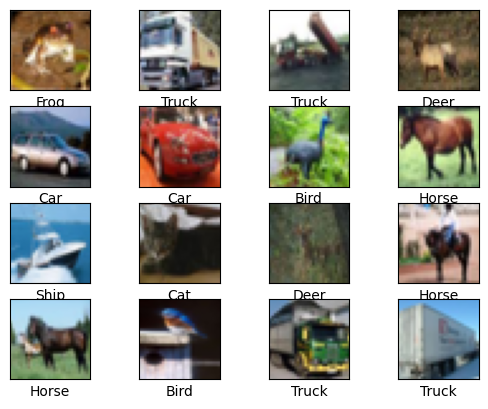

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

class_names = ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

(training_images, training_labels), (testing_images, testing_labels) = cifar10.load_data()
training_images, testing_images = training_images / 255, testing_images / 255

# print(training_labels)
for image in range(16):
    plt.subplot(4, 4, image + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(training_images[image])
    plt.xlabel(class_names[training_labels[image][0]])

plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(training_labels.reshape(-1, 1))
train_label_transformed = ohe.transform(training_labels.reshape(-1, 1)).toarray()
test_label_transformed = ohe.transform(testing_labels.reshape(-1, 1)).toarray()
print(ohe.categories_)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]


In [ ]:
train_label_transformed.shape

(50000, 10)

In [ ]:
x_train = training_images
y_train = train_label_transformed
x_test = testing_images[9000:]
y_test = test_label_transformed[9000:]
x_val = testing_images[:9000]
y_val = test_label_transformed[:9000]

In [ ]:
d = {'x_train': x_train, 'x_val': x_val, 'x_test': x_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}
for i in d:
    print(i, ' : ', d[i].shape, ' --> ', d[i].dtype)

x_train  :  (50000, 32, 32, 3)  -->  float64
x_val  :  (9000, 32, 32, 3)  -->  float64
x_test  :  (1000, 32, 32, 3)  -->  float64
y_train  :  (50000, 10)  -->  float64
y_val  :  (9000, 10)  -->  float64
y_test  :  (1000, 10)  -->  float64


In [ ]:
image_width = 32
image_height = 32
image_channels = 3
num_classes = 10

## Augmentation

In [ ]:
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        # tf.keras.layers.Resizing(image_height, image_width),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.05, width_factor=0.04
        ),
    ],
    name="augmentation_layer",
)

## Patch Creation

In [ ]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images,
                                           sizes=[1, self.patch_size, self.patch_size, 1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID'
                                           )
        #print("shape of created patches: ", patches.shape)
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        #print("after reshaping:", patches.shape)
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

## Patch encoder

In [ ]:
import numpy as np

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            np.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

## MLP

In [ ]:
def create_mlp(x, hidden_units, dropout_rate):
    for unit in hidden_units:
        x = tf.keras.layers.Dense(unit, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

## Define model hyperparameters

In [ ]:
patch_size = 10
projection_dim = 54  # Dimension of the projected patch embeddings
transformer_units = [
    projection_dim * 2,
    projection_dim
]
mlp_head_units = [
    512,
    256,
]

In [ ]:
input_shape = (image_height, image_width, 1)
(input_shape[0] // patch_size) * (input_shape[1] // patch_size)

9

## Model Architecture

In [ ]:
def create_visual_transformer(input_layer):
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    augmented = augmentation(input_layer)

    patches = Patches(patch_size)(augmented)

    embeddings = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer layers
    for _ in range(5):
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embeddings)
        attention_output = tf.keras.layers.MultiHeadAttention(num_heads=6, key_dim=256)(x1, x1)
        x2 = tf.keras.layers.Add()([attention_output, embeddings])
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = create_mlp(x3, transformer_units, 0.1)
        embeddings = tf.keras.layers.Add()([x3, x2])

    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embeddings)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.3)(representation)
    features = create_mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    classification = tf.keras.layers.Dense(num_classes, activation='softmax')(features)
    model = tf.keras.models.Model(inputs=(input_layer), outputs=classification)
    return model



In [ ]:
input = tf.keras.layers.Input(shape=(image_width, image_height, image_channels))

model = create_visual_transformer(input)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 augmentation_layer (Sequen  (None, 32, 32, 3)            7         ['input_6[0][0]']             
 tial)                                                                                            
                                                                                                  
 patches_5 (Patches)         (None, 9, 300)               0         ['augmentation_layer[0][0]']  
                                                                                                  
 patch_encoder_5 (PatchEnco  (None, 9, 54)                16740     ['patches_5[0][0]']     

In [ ]:
def run_experiment(model, x_train, y_train, x_val, y_val, num_epochs, batch_size):
    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])

    lr_reduction_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
                              patience=4,
                              min_delta=0.001,
                              monitor="val_accuracy",
                              restore_best_weights=True
                              )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[lr_reduction_callback, early_stopping],
    )

    return history

In [ ]:
history = run_experiment(model, x_train, y_train, x_val, y_val, num_epochs=10, batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 108s 34ms/step - loss: 0.9299 - accuracy: 0.6636 - val_loss: 1.0995 - val_accuracy: 0.6186 - lr: 5.0000e-04
Epoch 2/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.9212 - accuracy: 0.6695 - val_loss: 1.0918 - val_accuracy: 0.6222 - lr: 5.0000e-04
Epoch 3/10
1563/1563 [==============================] - 55s 35ms/step - loss: 0.9231 - accuracy: 0.6697 - val_loss: 1.0822 - val_accuracy: 0.6262 - lr: 5.0000e-04
Epoch 4/10
1563/1563 [==============================] - 51s 33ms/step - loss: 0.9117 - accuracy: 0.6717 - val_loss: 1.1114 - val_accuracy: 0.6194 - lr: 5.0000e-04
Epoch 5/10
1563/1563 [==============================] - 52s 33ms/step - loss: 0.9068 - accuracy: 0.6748 - val_loss: 1.0786 - val_accuracy: 0.6221 - lr: 5.0000e-04
Epoch 6/10
1562/1563 [============================>.] - ETA: 0s - loss: 0.8959 - accuracy: 0.6764
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1563/1563

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim( (0, AUC.shape[1]) )
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    plt.colorbar(c)
    show_values(c)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))
def plot_classification_report_(classification_report, title='Classification report ', cmap='RdBu'):
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for i in range(3):
        lines.remove('')
    for line in lines[1 : (len(lines) - 3)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


In [ ]:
y_pred = model.predict(x_test)

32/32 [==============================] - 1s 12ms/step


In [ ]:
y_pred_ = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test_, y_pred_, target_names=class_names)

In [ ]:
_, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

32/32 [==============================] - 1s 22ms/step - loss: 1.0446 - accuracy: 0.6300
Test accuracy: 63.0%


[0.75, 0.79, 0.77]
[0.69, 0.64, 0.66]
[0.56, 0.45, 0.5]
[0.44, 0.47, 0.45]
[0.61, 0.58, 0.6]
[0.52, 0.48, 0.5]
[0.63, 0.68, 0.66]
[0.68, 0.73, 0.71]
[0.75, 0.73, 0.74]
[0.63, 0.7, 0.66]
plotMat: [[0.75, 0.79, 0.77], [0.69, 0.64, 0.66], [0.56, 0.45, 0.5], [0.44, 0.47, 0.45], [0.61, 0.58, 0.6], [0.52, 0.48, 0.5], [0.63, 0.68, 0.66], [0.68, 0.73, 0.71], [0.75, 0.73, 0.74], [0.63, 0.7, 0.66]]
support: [107, 96, 100, 87, 91, 102, 91, 109, 104, 113]


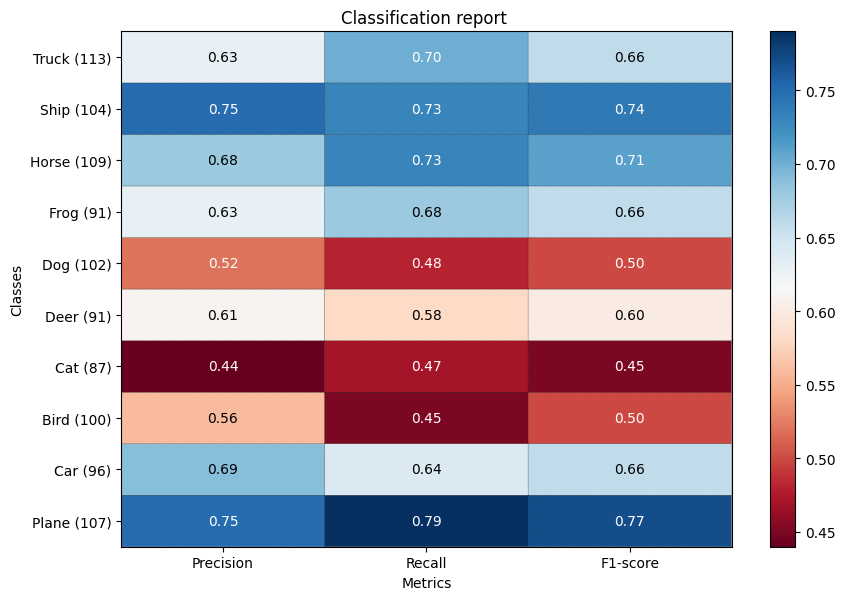

In [ ]:
plot_classification_report_(report)

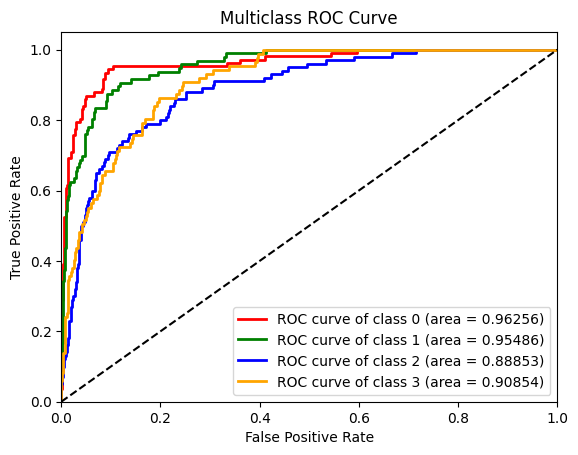

In [ ]:
# prompt: auc roc curve for multiclass classification using classification report
import random
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
y_pred_prob = y_pred

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4

# fpr, tpr, thresholds = roc_curve(y_val, y_probs_positive_class)
# roc_auc = auc(fpr, tpr)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.5f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()


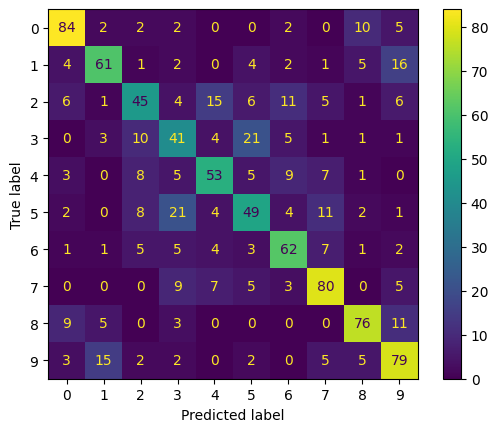

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred ,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()